In [1]:
import pandas as pd
import datetime
from math import ceil
import matplotlib.pyplot as plt
import torch
import numpy as np
from importlib import reload
import random
from random import shuffle
from dateutil.parser import parse

import rl4pm_lib.preprocessing as preprocessing
reload(preprocessing)
from IPython import display

In [2]:
test_df = pd.read_csv('datasets/test_df.csv')
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: parse(x))

train_df = pd.read_csv('datasets/train_df.csv')
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: parse(x))

### Propro like for SklEarn

In [3]:
import rl4pm_lib.preprocessing as preprocessing

column_feature = {'tt': 0, 'te': 1, 'tw': 2}
prepro = preprocessing.DfPreprocesser()
prepro.fit(train_df)
train_df_pr = prepro.transform(train_df)
test_df_pr = prepro.transform(test_df)

In [4]:
scaler = preprocessing.PaperScaler(column_feature)
scaler.fit(train_df_pr)
train_df_pr_sc = scaler.transform(train_df_pr)
test_df_pr_sc = scaler.transform(test_df_pr)

## Ok let's create data loader & dataset

In [5]:
from rl4pm_lib.lstm_supervised import ProcessesDataset

In [82]:
win_len = 2
batch_size = 512
n_lstm = 0
m_lstm = 2
hidden_layer = 128
n_epoch = 100
n_classes = len(set(train_df['activity'].values))

In [27]:
test_ds = ProcessesDataset(test_df_pr_sc, win_len)
train_ds = ProcessesDataset(train_df_pr_sc, win_len)

In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### Modles init

In [114]:
class NLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_layer, n_lstm, dropout=0.05):
        super(NLSTM, self).__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.lstms = torch.nn.ModuleList()
        self.n_lstm = n_lstm
        for i in range(n_lstm):
            if i == 0:
                self.lstms.append(torch.nn.LSTM(input_size, hidden_layer, 1))
            else:
                self.lstms.append(torch.nn.LSTM(hidden_layer, hidden_layer, 1))
        self.relu = torch.nn.ReLU()
        
    def forward(self, x, h=None):
        # print(x.shape)
        if self.n_lstm > 0:
            for i in range(self.n_lstm):
                if h is None:
                    x, h = self.lstms[i](x)
                else:
                    x, h = self.lstms[i](x, h)

                x = self.dropout(x)
                x = self.relu(x)
                
            return x, h
        else:
            return x, None

class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_layer, n_lstm, m_lstm, n_classes, dropout=0.05):
        super(Net, self).__init__()
        
        self.bb_lstm = NLSTM(input_size, hidden_layer, n_lstm, dropout=dropout)
        nlstm_in_size = hidden_layer
        if n_lstm == 0:
            nlstm_in_size = input_size
        self.ac_lstm = NLSTM(input_size=nlstm_in_size, hidden_layer=hidden_layer,
                             n_lstm=m_lstm, dropout=dropout)
        self.te_lstm = NLSTM(input_size=nlstm_in_size, hidden_layer=hidden_layer,
                             n_lstm=m_lstm, dropout=dropout)
                    
        
        self.relu = torch.nn.ReLU()
        self.fc_ac = torch.nn.Linear(hidden_layer, n_classes)
        self.fc_te = torch.nn.Linear(hidden_layer, 1)
        
        self.n_classes = n_classes
        self.n_lstm = n_lstm
        self.m_lstm = m_lstm
        self.hidden = hidden_layer
        
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        
            # back bone lstm
        x, h = self.bb_lstm(x)
        x = self.dropout(x)
        x = self.relu(x)
            
        x_ac, _ = self.ac_lstm(x, h)
        x_te, _ = self.te_lstm(x, h)
           
        x_te = self.dropout(x_te)
        x_ac = self.dropout(x_ac)
        
        x_te = self.relu(x_te)
        x_ac = self.relu(x_ac)
        x_ac = self.fc_ac(x_ac)
        x_te = self.fc_te(x_te)
        
        x_te = self.relu(x_te)
        x_ac = torch.nn.functional.softmax(x_ac, dim=-1)
        return x_te, x_ac

In [115]:
input_size = test_ds.tensor_data.shape[-1]

model = Net(input_size=input_size, hidden_layer=hidden_layer, n_lstm=n_lstm,
            m_lstm=m_lstm, n_classes=n_classes).to(device)

### Optimizers and losses

In [117]:
loss_ac = torch.nn.CrossEntropyLoss()

loss_te = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [118]:
from rl4pm_lib.lstm_supervised import train_one_epoch, for_evaluate
from rl4pm_lib.utils import get_accuracy, get_f1_score, get_log_loss, get_mae_days, plot_learning

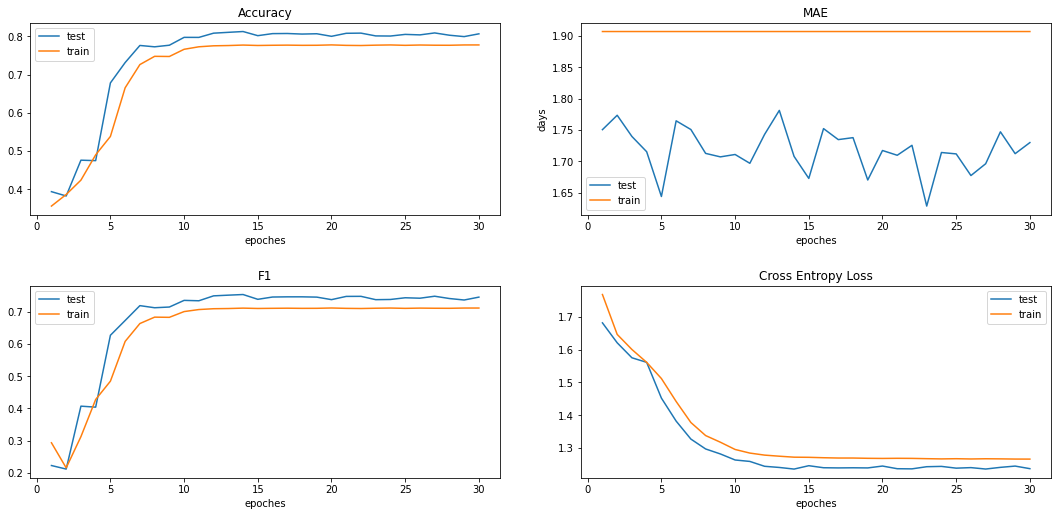

In [119]:
train_acc = []
test_acc = []

train_mae = []
test_mae = []

test_ce = []
train_ce = []

test_f1 = []
train_f1 = []

epoches = []

for ep in range(30):
    
    train_data = train_one_epoch(dataloader=train_dataloader, device=device,
                       model=model, optimizer=optimizer,
                       loss_ac=loss_ac, loss_te=loss_te, n_classes=n_classes)
    
    eval_data = for_evaluate(test_dataloader, model, n_classes=n_classes, device=device)
    
    epoches.append(ep+1)
    
    test_acc.append(get_accuracy(true=eval_data['true_label'],
                                 pred=eval_data['pred_label']))
    train_acc.append(get_accuracy(true=train_data['true_label'],
                                  pred=train_data['pred_label']))
    
    test_mae.append(get_mae_days(true=eval_data['true_tes'],
                                 pred=eval_data['pred_tes'], scaler=scaler))
    train_mae.append(get_mae_days(true=train_data['true_tes'],
                                  pred=train_data['pred_tes'], scaler=scaler))
    
    test_ce.append(get_log_loss(true=eval_data['true_label'],
                                     pred=eval_data['pred_label']))
    train_ce.append(get_log_loss(true=train_data['true_label'],
                                  pred=train_data['pred_label']))
    
    test_f1.append(get_f1_score(true=eval_data['true_label'],
                                 pred=eval_data['pred_label']))
    train_f1.append(get_f1_score(true=train_data['true_label'],
                                  pred=train_data['pred_label']))
    
    display.clear_output(wait=True)
    plot_learning(test_acc=test_acc, train_acc=train_acc,
                  test_mae=test_mae, train_mae=train_mae,
                  test_f1=test_f1, train_f1=train_f1,
                  test_ce=test_ce, train_ce=train_ce,
                  epoches=epoches
                  )

## Hyper param tune

In [150]:
def train_hyper(config, train_dataloader, test_dataloader, n_classes, n_epoches=40, checkpoint_dir=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Net(input_size=input_size, hidden_layer=config['hidden'], n_lstm=config['n_lstm'],
            m_lstm=config['m_lstm'], n_classes=n_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    
    loss_ac = torch.nn.CrossEntropyLoss()
    loss_te = torch.nn.SmoothL1Loss()
    for epoch in range(n_epoches):
        train_result = train_one_epoch(dataloader=train_dataloader, device=device, model=model, optimizer=optimizer,
                                       loss_ac=loss_ac, loss_te=loss_te, n_classes=n_classes)
        eval_data = for_evaluate(test_dataloader, model, n_classes=n_classes, device=device)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
            
        val_loss = get_log_loss(true=eval_data['true_label'],
                                pred=eval_data['pred_label'])
        vall_acc = get_accuracy(true=train_data['true_label'],
                                pred=train_data['pred_label'])
        tune.report(loss=val_loss, accuracy=vall_acc)

In [151]:
from functools import partial
import os
from torch.utils.data import random_split
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

data_dir = os.path.abspath("checkpoint")
config = {
        "n_lstm": tune.choice([1, 2, 3]),
        "m_lstm": tune.choice([1, 2, 3]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([128, 256]),
        "hidden": tune.choice([128, 200, 300])
    }

scheduler = ASHAScheduler(
        metric="accuracy",
        mode="max",
        max_t=200,
        grace_period=1,
        reduction_factor=2)

reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])

result = tune.run(partial(train_hyper, train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader, n_classes=6,
                          n_epoches=10
                         ),
                  resources_per_trial={"cpu": 2, "gpu": 1},
                  num_samples=1,
                  scheduler=scheduler,
                  config=config,
                  progress_reporter=reporter)


2021-06-09 19:54:33,419	WARNING experiment.py:293 -- No name detected on trainable. Using DEFAULT.
2021-06-09 19:54:33,419	INFO registry.py:64 -- Detected unknown callable for trainable. Converting to class.
2021-06-09 19:54:37,996	WARNING worker.py:1114 -- Warning: The actor ImplicitFunc has size 68880395 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-09 19:54:38,074	WARNING util.py:161 -- The `start_trial` operation took 2.034 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 11.6/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/12 CPUs, 1.0/1 GPUs, 0.0/4.78 GiB heap, 0.0/2.39 GiB objects
Result logdir: C:\Users\PC\ray_results\DEFAULT_2021-06-09_19-54-33
Number of trials: 1/1 (1 RUNNING)
+---------------------+----------+-------+--------------+----------+-------------+----------+----------+
| Trial name          | status   | loc   |   batch_size |   hidden |          lr |   m_lstm |   n_lstm |
|---------------------+----------+-------+--------------+----------+-------------+----------+----------|
| DEFAULT_5e311_00000 | RUNNING  |       |          256 |      128 | 0.000182385 |        2 |        1 |
+---------------------+----------+-------+--------------+----------+-------------+----------+----------+


Result for DEFAULT_5e311_00000:


2021-06-09 19:54:44,964	WARNING util.py:161 -- The `process_trial_save` operation took 1.185 s, which may be a performance bottleneck.
2021-06-09 19:54:47,440	WARNING util.py:161 -- The `process_trial_save` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_5e311_00000:
  accuracy: 0.7778032771836416
  date: 2021-06-09_19-54-48
  done: false
  experiment_id: c50def35184a4c34abf9339971023e68
  hostname: DESKTOP-L3AVIJ6
  iterations_since_restore: 3
  loss: 1.7319129705429077
  node_ip: 192.168.1.182
  pid: 7464
  should_checkpoint: true
  time_since_restore: 8.797980308532715
  time_this_iter_s: 2.463554859161377
  time_total_s: 8.797980308532715
  timestamp: 1623257688
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5e311_00000
  
== Status ==
Memory usage on this node: 13.9/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: 0.7778032771836416 | Iter 1.000: 0.7778032771836416
Resources requested: 2.0/12 CPUs, 1.0/1 GPUs, 0.0/4.78 GiB heap, 0.0/2.39 GiB objects
Result logdir: C:\Users\PC\ray_results\DEFAULT_2021-06-09_19-54-33
Number of trials: 1/1 (1 RUNNING)
+-----------

2021-06-09 19:54:49,882	WARNING util.py:161 -- The `process_trial_save` operation took 0.959 s, which may be a performance bottleneck.
2021-06-09 19:54:52,324	WARNING util.py:161 -- The `process_trial_save` operation took 0.960 s, which may be a performance bottleneck.
(pid=None) c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
2021-06-09 19:54:54,810	WARNING util.py:161 -- The `process_trial_save` operation took 1.014 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 13.9/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: 0.7778032771836416 | Iter 2.000: 0.7778032771836416 | Iter 1.000: 0.7778032771836416
Resources requested: 2.0/12 CPUs, 1.0/1 GPUs, 0.0/4.78 GiB heap, 0.0/2.39 GiB objects
Result logdir: C:\Users\PC\ray_results\DEFAULT_2021-06-09_19-54-33
Number of trials: 1/1 (1 RUNNING)
+---------------------+----------+--------------------+--------------+----------+-------------+----------+----------+---------+------------+----------------------+
| Trial name          | status   | loc                |   batch_size |   hidden |          lr |   m_lstm |   n_lstm |    loss |   accuracy |   training_iteration |
|---------------------+----------+--------------------+--------------+----------+-------------+----------+----------+---------+------------+----------------------|
| DEFAULT_5e311_00000 | R

2021-06-09 19:54:57,263	WARNING util.py:161 -- The `process_trial_save` operation took 0.972 s, which may be a performance bottleneck.
2021-06-09 19:54:59,803	WARNING util.py:161 -- The `process_trial_save` operation took 0.976 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 13.9/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: 0.7778032771836416 | Iter 4.000: 0.7778032771836416 | Iter 2.000: 0.7778032771836416 | Iter 1.000: 0.7778032771836416
Resources requested: 2.0/12 CPUs, 1.0/1 GPUs, 0.0/4.78 GiB heap, 0.0/2.39 GiB objects
Result logdir: C:\Users\PC\ray_results\DEFAULT_2021-06-09_19-54-33
Number of trials: 1/1 (1 RUNNING)
+---------------------+----------+--------------------+--------------+----------+-------------+----------+----------+--------+------------+----------------------+
| Trial name          | status   | loc                |   batch_size |   hidden |          lr |   m_lstm |   n_lstm |   loss |   accuracy |   training_iteration |
|---------------------+----------+--------------------+--------------+----------+-------------+----------+----------+--------+------------+----------------------|
| DEFAULT_5e31

2021-06-09 19:55:02,246	WARNING util.py:161 -- The `process_trial_save` operation took 0.966 s, which may be a performance bottleneck.


Result for DEFAULT_5e311_00000:
  accuracy: 0.7778032771836416
  date: 2021-06-09_19-55-03
  done: false
  experiment_id: c50def35184a4c34abf9339971023e68
  hostname: DESKTOP-L3AVIJ6
  iterations_since_restore: 9
  loss: 1.6077830791473389
  node_ip: 192.168.1.182
  pid: 7464
  should_checkpoint: true
  time_since_restore: 23.60642409324646
  time_this_iter_s: 2.4471936225891113
  time_total_s: 23.60642409324646
  timestamp: 1623257703
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5e311_00000
  


2021-06-09 19:55:04,705	WARNING util.py:161 -- The `process_trial_save` operation took 0.978 s, which may be a performance bottleneck.
2021-06-09 19:55:07,175	WARNING util.py:161 -- The `process_trial_save` operation took 0.968 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 13.9/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: 0.7778032771836416 | Iter 4.000: 0.7778032771836416 | Iter 2.000: 0.7778032771836416 | Iter 1.000: 0.7778032771836416
Resources requested: 2.0/12 CPUs, 1.0/1 GPUs, 0.0/4.78 GiB heap, 0.0/2.39 GiB objects
Result logdir: C:\Users\PC\ray_results\DEFAULT_2021-06-09_19-54-33
Number of trials: 1/1 (1 RUNNING)
+---------------------+----------+--------------------+--------------+----------+-------------+----------+----------+---------+------------+----------------------+
| Trial name          | status   | loc                |   batch_size |   hidden |          lr |   m_lstm |   n_lstm |    loss |   accuracy |   training_iteration |
|---------------------+----------+--------------------+--------------+----------+-------------+----------+----------+---------+------------+----------------------|
| DEFAULT_5

2021-06-09 19:55:08,167	WARNING util.py:161 -- The `process_trial_save` operation took 0.983 s, which may be a performance bottleneck.
(pid=7464) Windows fatal exception: access violation
(pid=7464) 
2021-06-09 19:55:08,278	INFO tune.py:549 -- Total run time: 34.86 seconds (33.65 seconds for the tuning loop).


== Status ==
Memory usage on this node: 13.9/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: 0.7778032771836416 | Iter 4.000: 0.7778032771836416 | Iter 2.000: 0.7778032771836416 | Iter 1.000: 0.7778032771836416
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/4.78 GiB heap, 0.0/2.39 GiB objects
Result logdir: C:\Users\PC\ray_results\DEFAULT_2021-06-09_19-54-33
Number of trials: 1/1 (1 TERMINATED)
+---------------------+------------+-------+--------------+----------+-------------+----------+----------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   hidden |          lr |   m_lstm |   n_lstm |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+----------+-------------+----------+----------+---------+------------+----------------------|
| DEFAULT_5e311_00000 | TERMINATED |       | 

(pid=None) c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
